# Doodle Recognition with OpenCV Similarity Matching

This notebook implements doodle recognition using OpenCV's (cv2) built-in similarity matching methods:

1. **cv2.matchTemplate()**: Template matching with normalized correlation
2. **Feature Matching**: Keypoint-based matching using SIFT/ORB detectors  
3. **Histogram Comparison**: Histogram-based similarity using multiple distance metrics
4. **Multi-Method**: Combines all methods for robust similarity scoring

No neural networks or traditional ML classifiers are used - just direct image-to-image similarity comparison.


In [23]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from matplotlib.patches import Rectangle

warnings.filterwarnings('ignore')
np.random.seed(42)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Data Loading


In [24]:
# Setup paths
doodle_dir = Path('doodles/doodle')

# Configuration - using ALL categories
NUM_CATEGORIES = None  # None means use all categories
SAMPLES_PER_CATEGORY = 1000  # Samples per category
IMAGE_SIZE = 64  # Resize images to this size
TEST_SIZE = 0.2  # 20% test set, 80% training set

# Get all categories
categories = sorted([d.name for d in doodle_dir.iterdir() if d.is_dir()])

# Select categories (use all if NUM_CATEGORIES is None)
if NUM_CATEGORIES is None:
    selected_categories = categories
else:
    selected_categories = categories[:NUM_CATEGORIES]

print(f"Configuration:")
print(f"  Using ALL categories ({len(categories)} total)")
print(f"  Samples per category: {SAMPLES_PER_CATEGORY}")
print(f"  Total samples: {len(selected_categories) * SAMPLES_PER_CATEGORY}")
print(f"  Image size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  Train/Test split: {(1-TEST_SIZE)*100:.0f}% / {TEST_SIZE*100:.0f}%")

# Load images
def load_images(categories, samples_per_category, image_size):
    """Load images from disk and preprocess them."""
    images = []
    labels = []
    
    for category in tqdm(categories, desc="Loading categories"):
        category_path = doodle_dir / category
        image_files = list(category_path.glob('*.png'))[:samples_per_category]
        
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img, (image_size, image_size))
                if img.mean() > 127:
                    img = 255 - img
                images.append(img)
                labels.append(category)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

print("\nLoading images...")
images, labels = load_images(selected_categories, SAMPLES_PER_CATEGORY, IMAGE_SIZE)
print(f"Loaded {len(images)} images")

# Encode labels and split
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train_img, X_test_img, y_train, y_test = train_test_split(
    images, encoded_labels, test_size=TEST_SIZE, random_state=42, stratify=encoded_labels
)

# Detailed split information
train_size = len(X_train_img)
test_size = len(X_test_img)
total_size = train_size + test_size

print(f"\n{'='*60}")
print(f"TRAIN/TEST SPLIT SUMMARY")
print(f"{'='*60}")
print(f"Training set: {train_size:,} images ({train_size/total_size*100:.1f}%)")
print(f"Test set:     {test_size:,} images ({test_size/total_size*100:.1f}%)")
print(f"Total:        {total_size:,} images")
print(f"{'='*60}")
print(f"\nSamples per class (approximate):")
print(f"  Training: ~{train_size // len(label_encoder.classes_)} per class")
print(f"  Test:     ~{test_size // len(label_encoder.classes_)} per class")


Configuration:
  Using ALL categories (340 total)
  Samples per category: 1000
  Total samples: 340000
  Image size: 64x64
  Train/Test split: 80% / 20%

Loading images...


Loading categories: 100%|██████████| 340/340 [02:09<00:00,  2.63it/s]


Loaded 340000 images

TRAIN/TEST SPLIT SUMMARY
Training set: 272,000 images (80.0%)
Test set:     68,000 images (20.0%)
Total:        340,000 images

Samples per class (approximate):
  Training: ~800 per class
  Test:     ~200 per class


## 2. OpenCV Similarity Matching Classifier


In [25]:
class CV2SimilarityClassifier:
    """
    Classifier using OpenCV's template matching and feature matching.
    Uses multiple similarity metrics from cv2.
    """
    
    def __init__(self, method='multi'):
        """
        Args:
            method: 'template' (cv2.matchTemplate), 'features' (keypoint matching), 
                   'histogram' (histogram comparison), or 'multi' (combines all)
        """
        self.method = method
        self.templates = {}
        self.classes_ = None
        
        # Initialize feature detectors
        if method in ['features', 'multi']:
            try:
                # Try SIFT first (better but requires opencv-contrib-python)
                self.detector = cv2.SIFT_create()
                self.matcher = cv2.BFMatcher()
                print("Using SIFT detector")
            except:
                # Fall back to ORB (built-in)
                self.detector = cv2.ORB_create()
                self.matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
                print("Using ORB detector")
    
    def fit(self, X, y):
        """Create template prototypes from training images."""
        self.classes_ = np.unique(y)
        
        for cls in self.classes_:
            class_samples = X[y == cls]
            # Store multiple templates per class (top samples)
            # Use mean as primary template
            self.templates[cls] = {
                'mean': np.mean(class_samples, axis=0).astype(np.uint8),
                'samples': class_samples[:10].astype(np.uint8)  # Store top 10 samples
            }
            
            # Precompute keypoints and descriptors for feature matching
            if self.method in ['features', 'multi']:
                self.templates[cls]['keypoints'] = []
                self.templates[cls]['descriptors'] = []
                for sample in self.templates[cls]['samples']:
                    kp, desc = self.detector.detectAndCompute(sample, None)
                    self.templates[cls]['keypoints'].append(kp)
                    self.templates[cls]['descriptors'].append(desc)
        
        return self
    
    def _template_match_score(self, img, template):
        """Use cv2.matchTemplate with multiple methods."""
        # Normalize images
        img_norm = cv2.normalize(img.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
        template_norm = cv2.normalize(template.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
        
        # Try different matching methods
        methods = [
            cv2.TM_CCOEFF_NORMED,  # Normalized correlation coefficient
            cv2.TM_CCORR_NORMED,   # Normalized cross-correlation
        ]
        
        scores = []
        for method in methods:
            result = cv2.matchTemplate(img_norm, template_norm, method)
            scores.append(np.max(result))
        
        return np.mean(scores)
    
    def _feature_match_score(self, img, template_data):
        """Match using keypoint features."""
        kp_img, desc_img = self.detector.detectAndCompute(img, None)
        
        if desc_img is None or len(kp_img) < 4:
            return 0.0
        
        best_matches = []
        for desc_template in template_data['descriptors']:
            if desc_template is None:
                continue
            
            try:
                if isinstance(self.matcher, cv2.BFMatcher) and self.matcher.getCrossCheck():
                    # ORB with Hamming distance
                    matches = self.matcher.match(desc_img, desc_template)
                    matches = sorted(matches, key=lambda x: x.distance)
                    best_matches.extend(matches[:20])  # Top 20 matches
                else:
                    # SIFT with ratio test
                    matches = self.matcher.knnMatch(desc_img, desc_template, k=2)
                    good_matches = []
                    for match_pair in matches:
                        if len(match_pair) == 2:
                            m, n = match_pair
                            if m.distance < 0.75 * n.distance:  # Lowe's ratio test
                                good_matches.append(m)
                    best_matches.extend(good_matches)
            except:
                continue
        
        if len(best_matches) == 0:
            return 0.0
        
        # Score based on number of good matches
        match_score = len(best_matches) / max(len(kp_img), 1)
        return min(match_score, 1.0)
    
    def _histogram_match_score(self, img, template):
        """Compare histograms using multiple methods."""
        # Calculate histograms
        hist_img = cv2.calcHist([img], [0], None, [256], [0, 256])
        hist_template = cv2.calcHist([template], [0], None, [256], [0, 256])
        
        # Normalize
        cv2.normalize(hist_img, hist_img, 0, 1, cv2.NORM_MINMAX)
        cv2.normalize(hist_template, hist_template, 0, 1, cv2.NORM_MINMAX)
        
        # Compare using multiple methods
        methods = [
            cv2.HISTCMP_CORREL,      # Correlation
            cv2.HISTCMP_INTERSECT,   # Intersection
            cv2.HISTCMP_BHATTACHARYYA # Bhattacharyya distance
        ]
        
        scores = []
        for method in methods:
            score = cv2.compareHist(hist_img, hist_template, method)
            if method == cv2.HISTCMP_BHATTACHARYYA:
                # Lower is better for Bhattacharyya, convert to similarity
                score = 1.0 - min(score, 1.0)
            scores.append(score)
        
        return np.mean(scores)
    
    def _compute_similarity(self, img, template_data):
        """Compute similarity using selected method(s)."""
        template = template_data['mean']
        scores = []
        
        if self.method in ['template', 'multi']:
            scores.append(self._template_match_score(img, template))
        
        if self.method in ['features', 'multi']:
            scores.append(self._feature_match_score(img, template_data))
        
        if self.method in ['histogram', 'multi']:
            scores.append(self._histogram_match_score(img, template))
        
        return np.mean(scores) if scores else 0.0
    
    def predict(self, X):
        """Predict class labels by finding most similar template."""
        predictions = []
        for img in tqdm(X, desc="CV2 similarity matching"):
            similarities = {}
            for cls in self.classes_:
                similarity = self._compute_similarity(img.astype(np.uint8), self.templates[cls])
                similarities[cls] = similarity
            predictions.append(max(similarities, key=similarities.get))
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Return similarity scores as probabilities."""
        probas = []
        for img in X:
            similarities = np.array([
                self._compute_similarity(img.astype(np.uint8), self.templates[cls])
                for cls in self.classes_
            ])
            # Normalize to probabilities
            similarities = np.maximum(similarities, 0)  # Ensure non-negative
            if similarities.sum() > 0:
                probas.append(similarities / similarities.sum())
            else:
                probas.append(np.ones(len(self.classes_)) / len(self.classes_))
        return np.array(probas)

print("CV2 Similarity Classifier defined!")


CV2 Similarity Classifier defined!


## 3. Train and Evaluate


In [26]:
# Train CV2 similarity classifier with multi-method approach
print("Training CV2 Similarity Classifier (multi-method)...")
print("This combines template matching, feature matching, and histogram comparison\n")

cv2_clf_multi = CV2SimilarityClassifier(method='multi')
cv2_clf_multi.fit(X_train_img, y_train)

# Evaluate on a subset of test data (cv2 matching can be slow)
test_subset_size = min(500, len(X_test_img))
test_indices = np.random.choice(len(X_test_img), test_subset_size, replace=False)
X_test_subset = X_test_img[test_indices]
y_test_subset = y_test[test_indices]

print(f"\nEvaluating on {test_subset_size} test samples...")
y_pred_cv2_multi = cv2_clf_multi.predict(X_test_subset)
cv2_multi_accuracy = accuracy_score(y_test_subset, y_pred_cv2_multi)
print(f"\nCV2 Multi-Method Accuracy: {cv2_multi_accuracy:.4f} ({cv2_multi_accuracy*100:.2f}%)")


Training CV2 Similarity Classifier (multi-method)...
This combines template matching, feature matching, and histogram comparison

Using SIFT detector

Evaluating on 500 test samples...


CV2 similarity matching: 100%|██████████| 500/500 [01:24<00:00,  5.93it/s]


CV2 Multi-Method Accuracy: 0.1400 (14.00%)


## 4. Save Model


In [27]:
# Save the trained similarity model
import pickle
import json
from pathlib import Path

# Create directory for similarity model
save_dir = Path('similarity_model')
save_dir.mkdir(exist_ok=True)

# Create a clean copy of the classifier without keypoints and detector/matcher
# Keypoints are not needed for prediction - only descriptors are used
# Detector/matcher will be recreated on load
# Use __new__ to create instance without calling __init__ (which creates detector)
clf_to_save = object.__new__(type(cv2_clf_multi))
clf_to_save.method = cv2_clf_multi.method
clf_to_save.classes_ = cv2_clf_multi.classes_
clf_to_save.templates = {}
clf_to_save.detector = None  # Will be recreated on load
clf_to_save.matcher = None   # Will be recreated on load

for cls in cv2_clf_multi.templates:
    clf_to_save.templates[cls] = {
        'mean': cv2_clf_multi.templates[cls]['mean'].copy(),
        'samples': cv2_clf_multi.templates[cls]['samples'].copy()
    }
    # Copy descriptors but skip keypoints (not needed and can't be pickled)
    if 'descriptors' in cv2_clf_multi.templates[cls]:
        clf_to_save.templates[cls]['descriptors'] = [
            desc.copy() if desc is not None else None 
            for desc in cv2_clf_multi.templates[cls]['descriptors']
        ]

# Save the classifier
with open(save_dir / 'classifier.pkl', 'wb') as f:
    pickle.dump(clf_to_save, f)
print(f"Classifier saved to {save_dir / 'classifier.pkl'}")

# Save label mappings
label_mappings = {
    'label_to_idx': {label: idx for idx, label in enumerate(label_encoder.classes_)},
    'idx_to_label': {str(idx): label for idx, label in enumerate(label_encoder.classes_)}
}

with open(save_dir / 'label_mappings.json', 'w') as f:
    json.dump(label_mappings, f, indent=2)
print(f"Label mappings saved to {save_dir / 'label_mappings.json'}")

# Save model info
model_info = {
    'model_type': 'CV2SimilarityClassifier',
    'method': 'multi',
    'image_size': IMAGE_SIZE,
    'num_classes': len(label_encoder.classes_),
    'accuracy': float(cv2_multi_accuracy),
    'description': 'OpenCV similarity matching using template matching, feature matching, and histogram comparison'
}

with open(save_dir / 'model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"Model info saved to {save_dir / 'model_info.json'}")

print(f"\n✓ Model successfully saved to {save_dir}/")
print(f"  - classifier.pkl: Trained CV2SimilarityClassifier")
print(f"  - label_mappings.json: Label encodings")
print(f"  - model_info.json: Model metadata")


Classifier saved to similarity_model/classifier.pkl
Label mappings saved to similarity_model/label_mappings.json
Model info saved to similarity_model/model_info.json

✓ Model successfully saved to similarity_model/
  - classifier.pkl: Trained CV2SimilarityClassifier
  - label_mappings.json: Label encodings
  - model_info.json: Model metadata


Comparing different CV2 similarity methods...

Testing template method...


CV2 similarity matching: 100%|██████████| 500/500 [00:15<00:00, 32.41it/s]


  Accuracy: 0.1700 (17.00%)

Testing histogram method...


CV2 similarity matching: 100%|██████████| 500/500 [00:03<00:00, 148.71it/s]

  Accuracy: 0.0020 (0.20%)

CV2 Method Comparison:
  CV2-Template        : 0.1700 (17.00%)
  CV2-Multi           : 0.1400 (14.00%)
  CV2-Histogram       : 0.0020 (0.20%)


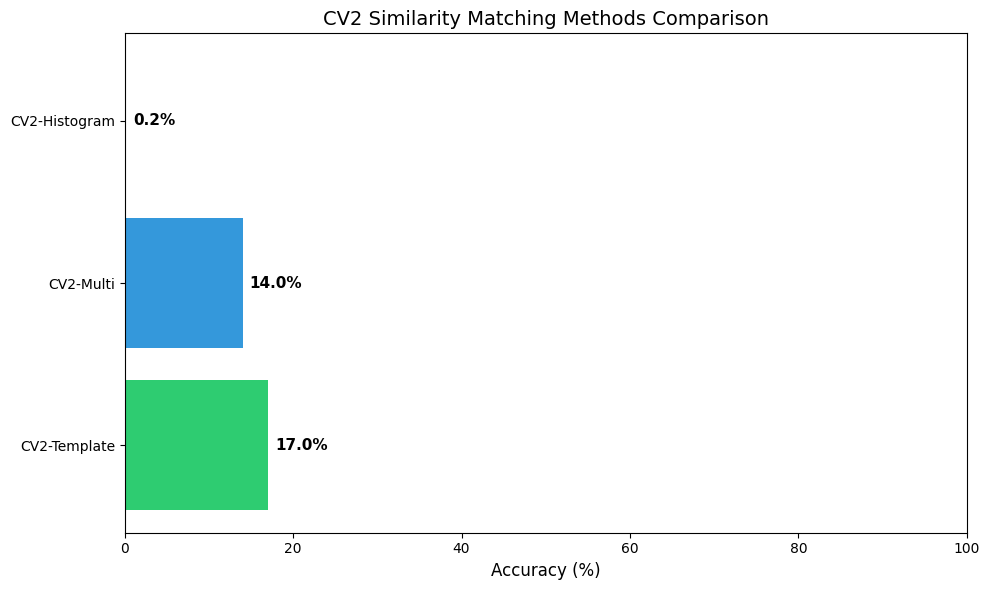

In [28]:
# Compare different CV2 methods
print("Comparing different CV2 similarity methods...\n")

cv2_results = {}
methods_to_test = ['template', 'histogram']  # Skip 'features' and 'multi' for speed

for method in methods_to_test:
    print(f"Testing {method} method...")
    cv2_clf = CV2SimilarityClassifier(method=method)
    cv2_clf.fit(X_train_img, y_train)
    
    # Use smaller subset for faster evaluation
    y_pred_cv2 = cv2_clf.predict(X_test_subset)
    acc = accuracy_score(y_test_subset, y_pred_cv2)
    cv2_results[f'CV2-{method.capitalize()}'] = acc
    print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)\n")

# Add multi-method result
cv2_results['CV2-Multi'] = cv2_multi_accuracy

print("CV2 Method Comparison:")
for method, acc in sorted(cv2_results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {method:20s}: {acc:.4f} ({acc*100:.2f}%)")

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#3498db', '#e74c3c']
sorted_cv2 = dict(sorted(cv2_results.items(), key=lambda x: x[1], reverse=True))
bars = ax.barh(list(sorted_cv2.keys()), [v * 100 for v in sorted_cv2.values()], color=colors)
ax.set_xlabel('Accuracy (%)', fontsize=12)
ax.set_title('CV2 Similarity Matching Methods Comparison', fontsize=14)
ax.set_xlim(0, 100)

for bar in bars:
    width = bar.get_width()
    ax.annotate(f'{width:.1f}%', xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Visualizations


Visualizing cv2 template matching...



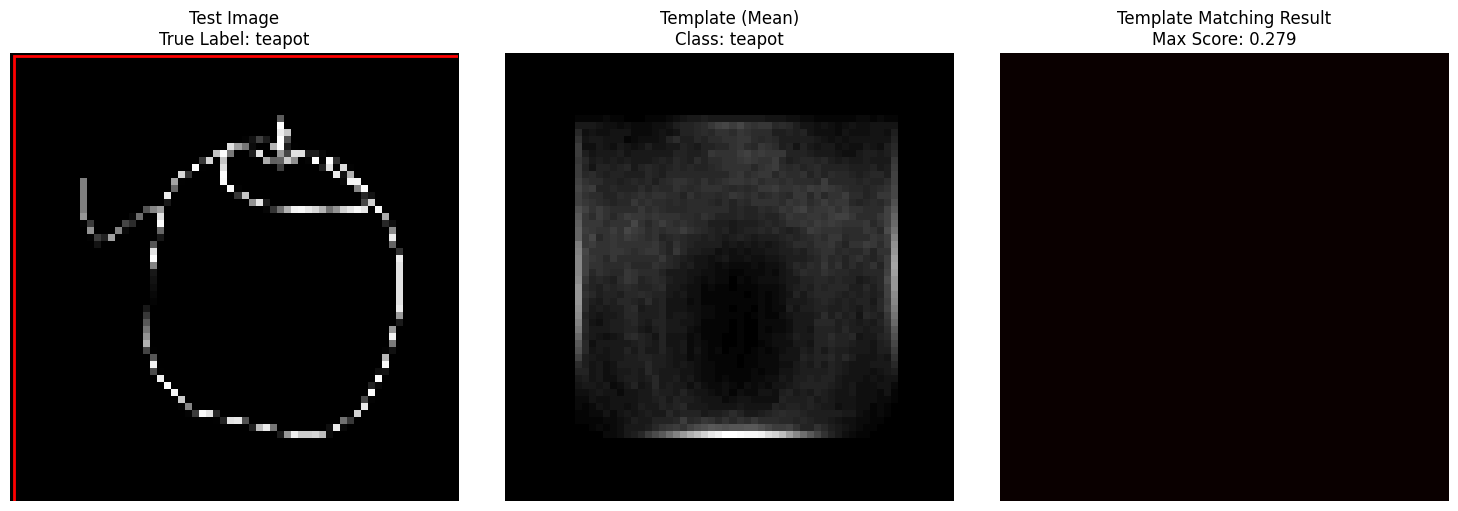

Template matching score: 0.2787


In [29]:
# Visualize cv2 template matching
print("Visualizing cv2 template matching...\n")

# Get a sample test image
sample_test_img = X_test_img[0]
sample_test_label = y_test[0]

# Get the template for the true class
true_class = sample_test_label
template = cv2_clf_multi.templates[true_class]['mean']

# Perform template matching
img_norm = cv2.normalize(sample_test_img.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
template_norm = cv2.normalize(template.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)

result = cv2.matchTemplate(img_norm, template_norm, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_test_img, cmap='gray')
axes[0].set_title(f'Test Image\nTrue Label: {label_encoder.classes_[sample_test_label]}')
axes[0].axis('off')

axes[1].imshow(template, cmap='gray')
axes[1].set_title(f'Template (Mean)\nClass: {label_encoder.classes_[true_class]}')
axes[1].axis('off')

axes[2].imshow(result, cmap='hot')
axes[2].set_title(f'Template Matching Result\nMax Score: {max_val:.3f}')
axes[2].axis('off')

# Draw rectangle around best match location
h, w = template.shape
rect = Rectangle(max_loc, w, h, linewidth=2, edgecolor='red', facecolor='none')
axes[0].add_patch(rect)

plt.tight_layout()
plt.show()

print(f"Template matching score: {max_val:.4f}")


In [30]:
# Visualize feature matching (if available)
try:
    # Get detector used
    detector = cv2_clf_multi.detector
    
    # Get two images from same class
    class_idx = 0
    img1 = X_train_img[y_train == class_idx][0]
    img2 = X_train_img[y_train == class_idx][1]
    
    # Detect keypoints and descriptors
    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)
    
    # Match features
    if isinstance(cv2_clf_multi.matcher, cv2.BFMatcher) and cv2_clf_multi.matcher.getCrossCheck():
        # ORB matching
        matches = cv2_clf_multi.matcher.match(desc1, desc2)
        matches = sorted(matches, key=lambda x: x.distance)[:20]
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    else:
        # SIFT matching with ratio test
        matches = cv2_clf_multi.matcher.knnMatch(desc1, desc2, k=2)
        good_matches = []
        for match_pair in matches:
            if len(match_pair) == 2:
                m, n = match_pair
                if m.distance < 0.75 * n.distance:
                    good_matches.append(m)
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(f'Image 1\nKeypoints: {len(kp1)}')
    axes[0].axis('off')
    
    axes[1].imshow(img_matches, cmap='gray')
    axes[1].set_title(f'Feature Matches\nMatches: {len(matches) if isinstance(matches, list) else len(good_matches)}')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Detected {len(kp1)} keypoints in image 1")
    print(f"Detected {len(kp2)} keypoints in image 2")
    print(f"Found {len(matches) if isinstance(matches, list) else len(good_matches)} good matches")
    
except Exception as e:
    print(f"Feature matching visualization skipped: {e}")
    print("(This is normal if SIFT is not available)")


Feature matching visualization skipped: 'cv2.BFMatcher' object has no attribute 'getCrossCheck'
(This is normal if SIFT is not available)
